### Introduction

#### Importing necessary libraries

In [1]:
#Importing necessary libraries

import glob
import os
import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.4)#for label size
sns.set(style='ticks')

import pandas as pd
import numpy as np

#Various sklearn utilities and metrics
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals import joblib

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier)

#Import categorical encoding library
import category_encoders as ce

#### Getting local directory and loading data

In [2]:
#Get current working directory
cwd = os.getcwd()
#Read energy simulation results
Results = pd.read_csv(cwd + "\\Energy_Results.csv")

In [3]:
Results.head(5)

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,...,AverageMRT,MinMRT,MaxMRT,AverageRH,MinRH,MaxRH,PeakCoolingLoad,PeakHeatingLoad,CoolingSizing,HeatingSizing
0,1,Core,20,DP,0.2,0.5,11,1,311.812896,20.883695,...,24.005318,22.196365,24.608786,52.766281,11.492039,81.201879,549.9763,0.0,632.47274,0.0
1,1,Core,20,DP,0.2,0.5,11,2,300.340893,0.626567,...,24.005314,22.196309,24.608843,52.423143,12.634105,81.096689,549.9763,0.0,632.47274,0.0
2,1,Core,20,DP,0.2,0.5,16,0,721.700049,301.654383,...,24.274933,23.090055,25.423161,54.297460,12.561028,78.194042,549.9763,0.0,632.47274,0.0
3,1,Core,20,DP,0.2,0.5,16,1,710.907858,138.222897,...,24.274645,23.088821,25.422741,54.407838,12.591474,78.193935,549.9763,0.0,632.47274,0.0
4,1,Core,20,DP,0.2,0.5,16,2,694.776674,79.718053,...,24.274726,23.088366,25.423729,54.590228,13.629492,78.255193,549.9763,0.0,632.47274,0.0


### Data Preprocessing

#### Check unique values of categorical variables

In [4]:
#Check unique values of categorical variables
print(Results['Orientation'].unique())
print(Results['GlazingType'].unique())
print(Results['HVAC'].unique())

['Core' 'East' 'North' 'South' 'West']
['DP' 'TP']
[11 16  7]


#### Turn categorical variables to numeric labels

In [5]:
#Label encoding of categorical features

or_Label = LabelEncoder()
orientation_labels = or_Label.fit_transform(Results['Orientation'])
orientation_mapping = {index: label for index, label in enumerate(or_Label.classes_)}
print("Orientation label mapping:", orientation_mapping)
Results['Orientation'] = orientation_labels

glz_Label = LabelEncoder()
glazing_labels = glz_Label.fit_transform(Results['GlazingType'])
glz_mapping = {index: label for index, label in enumerate(glz_Label.classes_)}
print("Glazing Type label mapping:", glz_mapping)
Results['GlazingType'] = glazing_labels

hvac_Label = LabelEncoder()
hvac_labels = hvac_Label.fit_transform(Results['HVAC'])
hvac_mapping = {index: label for index, label in enumerate(hvac_Label.classes_)}
print("HVAC Type label mapping:", hvac_mapping)
Results['HVAC'] = hvac_labels

Orientation label mapping: {0: 'Core', 1: 'East', 2: 'North', 3: 'South', 4: 'West'}
Glazing Type label mapping: {0: 'DP', 1: 'TP'}
HVAC Type label mapping: {0: 7, 1: 11, 2: 16}


In [6]:
Results.head()

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,...,AverageMRT,MinMRT,MaxMRT,AverageRH,MinRH,MaxRH,PeakCoolingLoad,PeakHeatingLoad,CoolingSizing,HeatingSizing
0,1,0,20,0,0.2,0.5,1,1,311.812896,20.883695,...,24.005318,22.196365,24.608786,52.766281,11.492039,81.201879,549.9763,0.0,632.47274,0.0
1,1,0,20,0,0.2,0.5,1,2,300.340893,0.626567,...,24.005314,22.196309,24.608843,52.423143,12.634105,81.096689,549.9763,0.0,632.47274,0.0
2,1,0,20,0,0.2,0.5,2,0,721.700049,301.654383,...,24.274933,23.090055,25.423161,54.297460,12.561028,78.194042,549.9763,0.0,632.47274,0.0
3,1,0,20,0,0.2,0.5,2,1,710.907858,138.222897,...,24.274645,23.088821,25.422741,54.407838,12.591474,78.193935,549.9763,0.0,632.47274,0.0
4,1,0,20,0,0.2,0.5,2,2,694.776674,79.718053,...,24.274726,23.088366,25.423729,54.590228,13.629492,78.255193,549.9763,0.0,632.47274,0.0


In [7]:
Results.iloc[:,:13].head()

,ClimateZone,Orientation,WWR,GlazingType,SHGC,OverhangLength,HVAC,HeatRecovery,Cooling,Heating,Lighting,Fans,Pumps
0,1,0,20,0,0.2,0.5,1,1,311.812896,20.883695,612.913717,58.941109,92.912378
1,1,0,20,0,0.2,0.5,1,2,300.340893,0.626567,612.913717,58.863011,92.166292
2,1,0,20,0,0.2,0.5,2,0,721.700049,301.654383,612.913717,267.528228,46.442213
3,1,0,20,0,0.2,0.5,2,1,710.907858,138.222897,612.913717,267.528228,34.807325
4,1,0,20,0,0.2,0.5,2,2,694.776674,79.718053,612.913717,267.528228,28.000885


#### Encode all categorical variables using Category Encoders

In [8]:
#Encoding with category_encoders library

#Feature variables
X = Results.iloc[:, :8]

#Target variable
y = (Results.iloc[:, 8] + Results.iloc[:, 9] + Results.iloc[:, 10] + Results.iloc[:, 11] + 
     Results.iloc[:, 12])

#Binary encoding
binary = ce.BinaryEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_bin = binary.transform(X)

#Backward Difference encoding
backward = ce.BackwardDifferenceEncoder(verbose=1, drop_invariant=True, 
                                        cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_bd = backward.transform(X)

#Hashing encoding
hashing = ce.HashingEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_hash = hashing.transform(X)

#Helmert encoding
helmert = ce.HelmertEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_helmert = helmert.transform(X)

#One-hot-encoding
oneHot = ce.OneHotEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_onh = oneHot.transform(X)

#Ordinal encoding
ordinal = ce.OrdinalEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_ord = ordinal.transform(X)

#Leave one out encoding
lou = ce.LeaveOneOutEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_lou = lou.transform(X)

#Polynomial encoding
polynomial = ce.PolynomialEncoder(verbose=1, drop_invariant=True, 
                                  cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_poly = polynomial.transform(X)

#Sum encoding
sumenc = ce.SumEncoder(verbose=1, drop_invariant=True, 
                       cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_sum = sumenc.transform(X)

#### Save encoded data into a python dictionary for later use

In [9]:
#Save all encodings in a python dictionary
processed_data = {'binary': Results_bin, 'backward': Results_bd, 'hashing': Results_hash, 'helmert': Results_helmert, 
                  'oneHot': Results_onh, 'ordinal': Results_ord, 'lou': Results_lou, 'polynomial': Results_poly,
                  'sumenc': Results_sum}

#Save encodings to disk for later use
#np.save('Encoded_data.npy', processed_data)

#### Normalize target variable and generate 10 classes

In [10]:
#Normalize consumption to room floor area and generate two classes
y_norm = y / 16

y_classes = np.empty((len(y_norm),1))

for i in range(0, len(y_norm)):
    if(y_norm[i] < np.percentile(y_norm, q=50)):
        y_classes[i] = 0
    else:
        y_classes[i] = 1

In [11]:
print(np.percentile(y_norm, q=50))
print(y_norm.max())

103.75782267597988
332.40208781570914


#### Save classes array to the disk

In [12]:
#Save the classes information to disk for later use, uncomment this if you are running for the first time
#np.save('BinaryClasses.npy', y_classes)

#### Load classes array from the disk

In [19]:
y_classes = np.load('BinaryClasses.npy')

#### Helper function to plot learning curves

Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=8, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(15,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='accuracy', train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Train RandomForest Classifier on different categorical encodings

#### Binary encoding

             precision    recall  f1-score   support

          0       0.96      0.96      0.96     18185
          1       0.96      0.96      0.96     18067

avg / total       0.96      0.96      0.96     36252



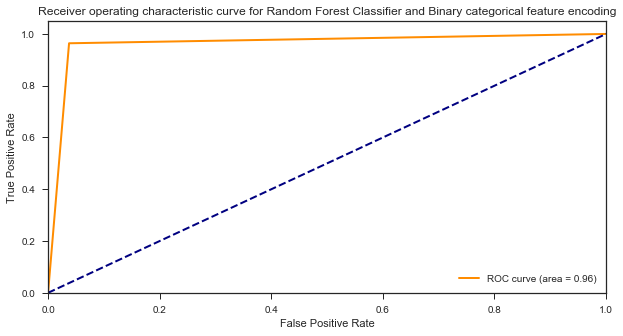

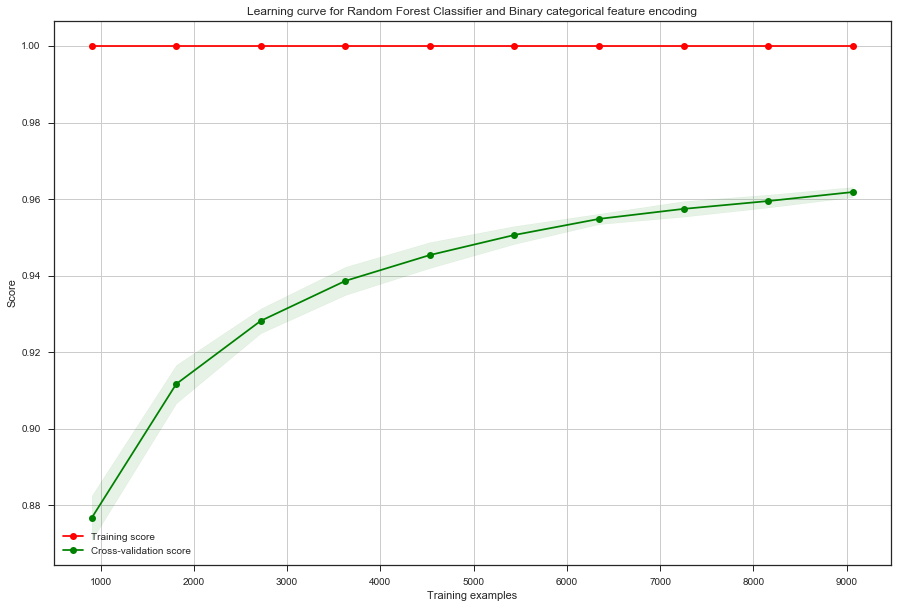

In [21]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_bin, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_bin = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_bin, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Binary categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Binary.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Binary categorical feature encoding', 
                    Results_bin.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Binary.png', dpi=200)

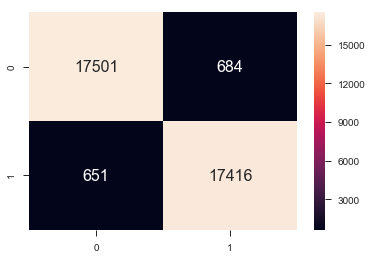

In [22]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_bin)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Backward differencing encoding

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     18185
          1       0.97      0.97      0.97     18067

avg / total       0.97      0.97      0.97     36252



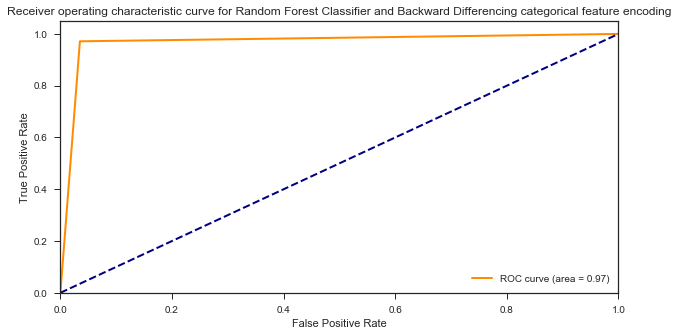

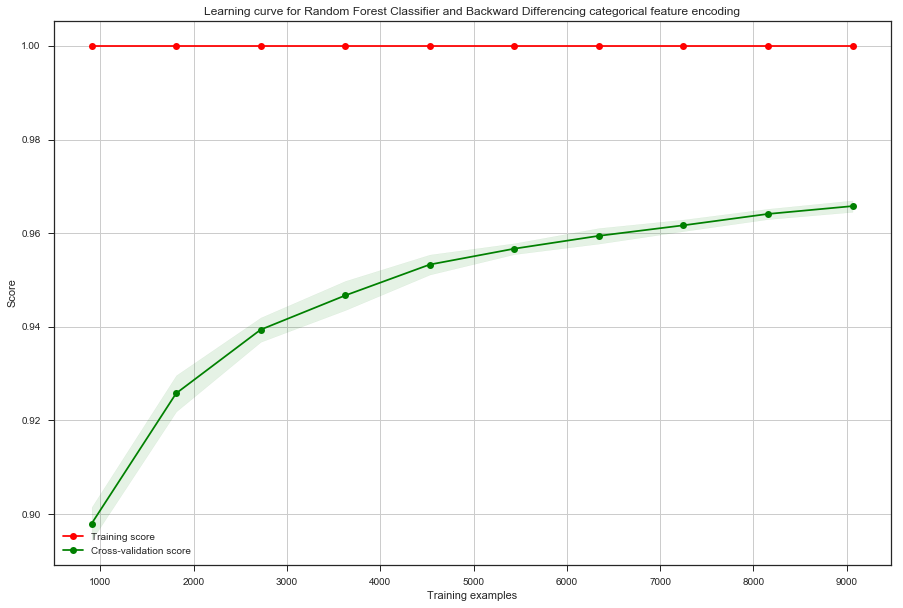

In [23]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_bd, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_bd = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_bd, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_bd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Backward Differencing categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_BackwardDifferencing.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Backward Differencing categorical feature encoding', 
                    Results_bd.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_BackwardDifferencing.png', dpi=200)

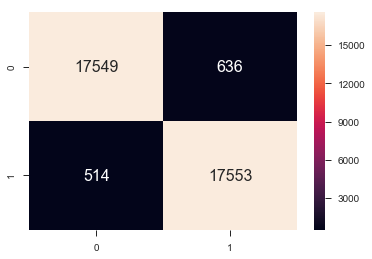

In [24]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_bd)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Hashing encoding

             precision    recall  f1-score   support

          0       0.56      0.50      0.53     18185
          1       0.54      0.60      0.57     18067

avg / total       0.55      0.55      0.55     36252



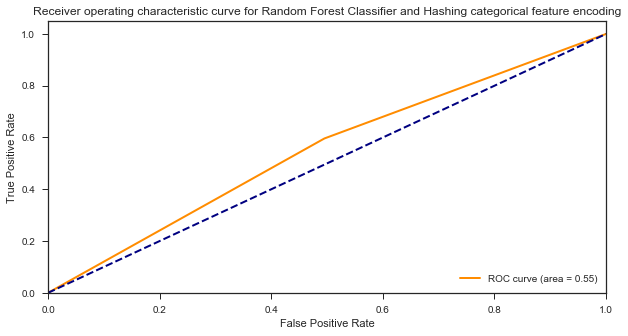

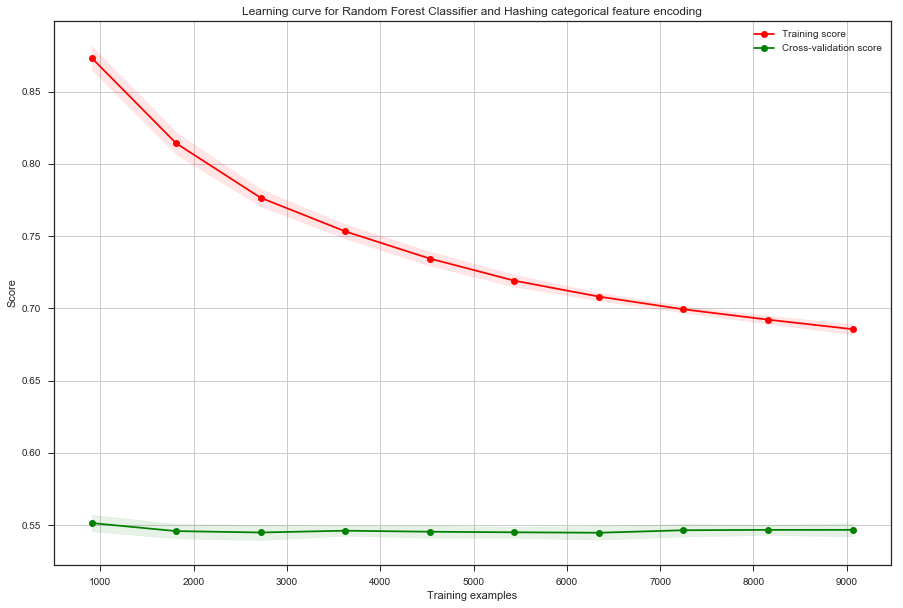

In [25]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_hash, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_hash = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_hash, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_hash)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Hashing categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Hashing.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Hashing categorical feature encoding', 
                    Results_hash.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Hashing.png', dpi=200)

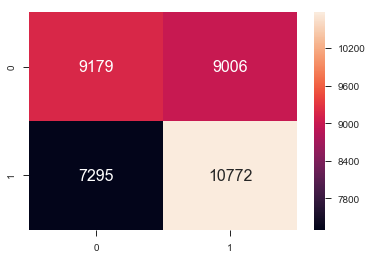

In [26]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_hash)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Helmert encoding

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     18185
          1       0.97      0.97      0.97     18067

avg / total       0.97      0.97      0.97     36252



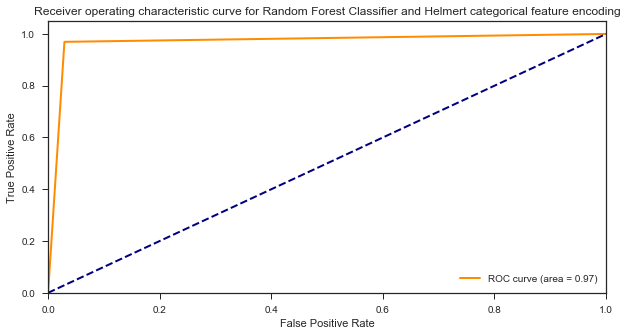

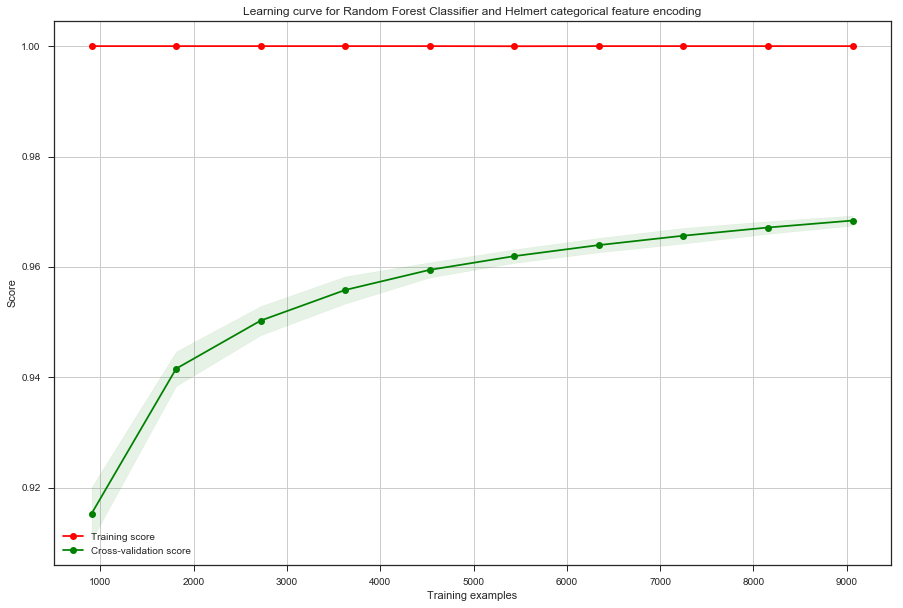

In [27]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_helmert, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_helmert = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_helmert, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_helmert)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Helmert categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Helmert.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Helmert categorical feature encoding', 
                    Results_helmert.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Helmert.png', dpi=200)

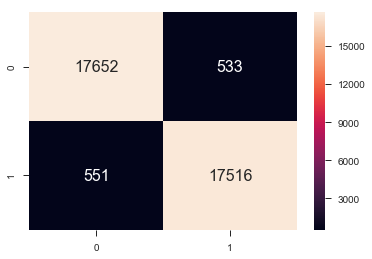

In [28]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_helmert)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Leave one out encoding

             precision    recall  f1-score   support

          0       0.95      0.95      0.95     18185
          1       0.95      0.95      0.95     18067

avg / total       0.95      0.95      0.95     36252



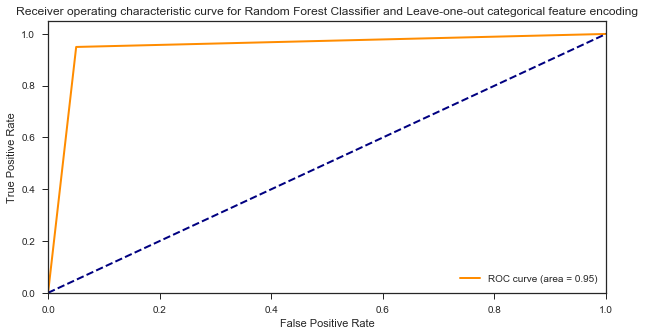

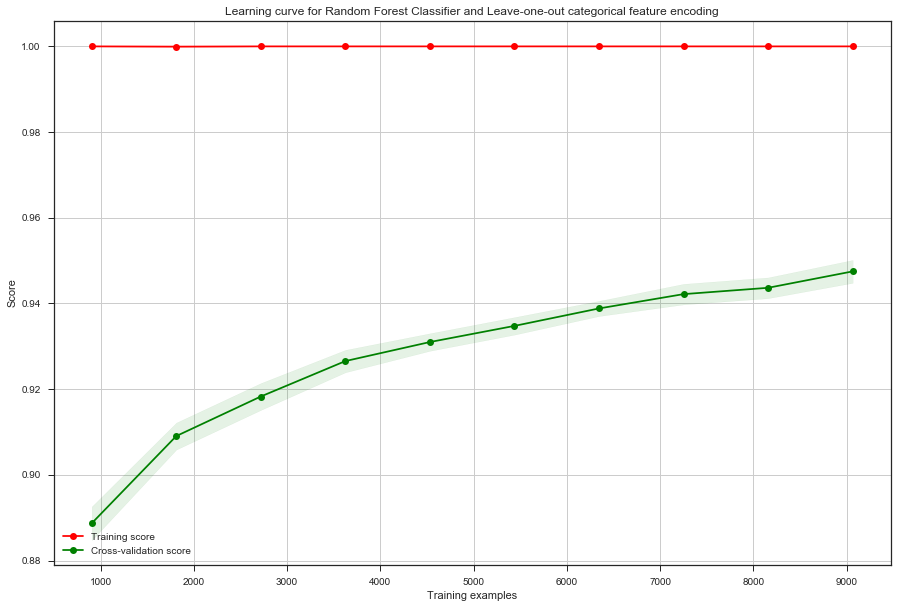

In [29]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_lou, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_lou = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_lou, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lou)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Leave-one-out categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_LOU.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Leave-one-out categorical feature encoding', 
                    Results_lou.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_LOU.png', dpi=200)

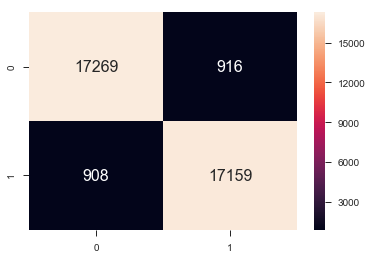

In [30]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_lou)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### One hot encoding

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     18185
          1       0.97      0.97      0.97     18067

avg / total       0.97      0.97      0.97     36252



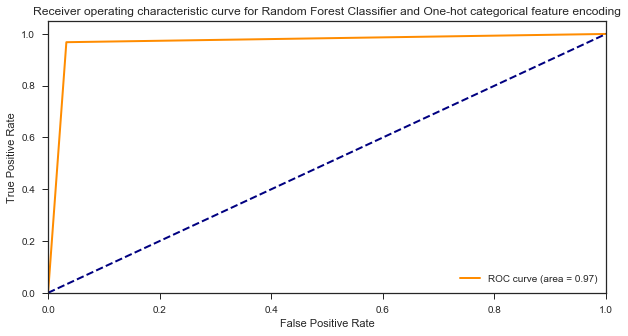

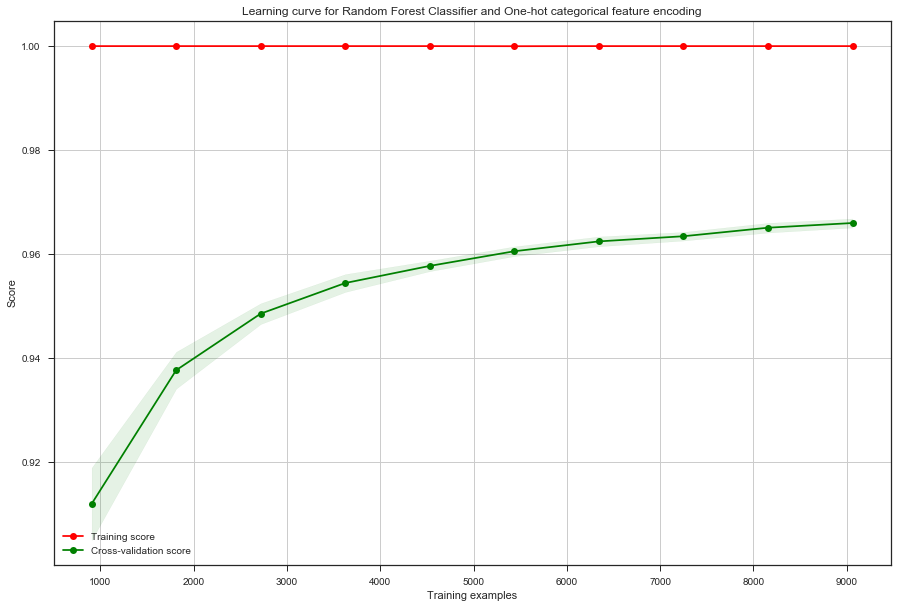

In [31]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_onh, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_onh = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_onh, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_onh)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and One-hot categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_ONH.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and One-hot categorical feature encoding', 
                    Results_onh.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_ONH.png', dpi=200)

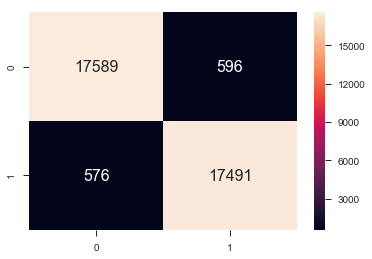

In [32]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_onh)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Ordinal encoding

             precision    recall  f1-score   support

          0       0.96      0.94      0.95     18185
          1       0.94      0.96      0.95     18067

avg / total       0.95      0.95      0.95     36252



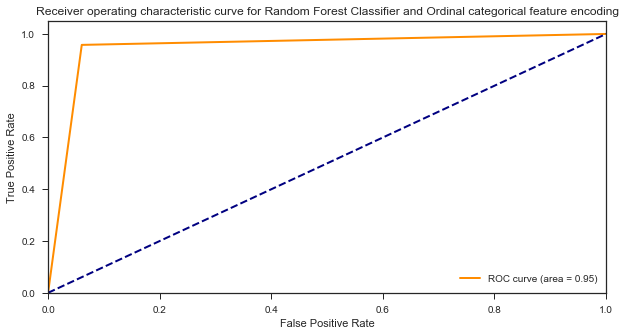

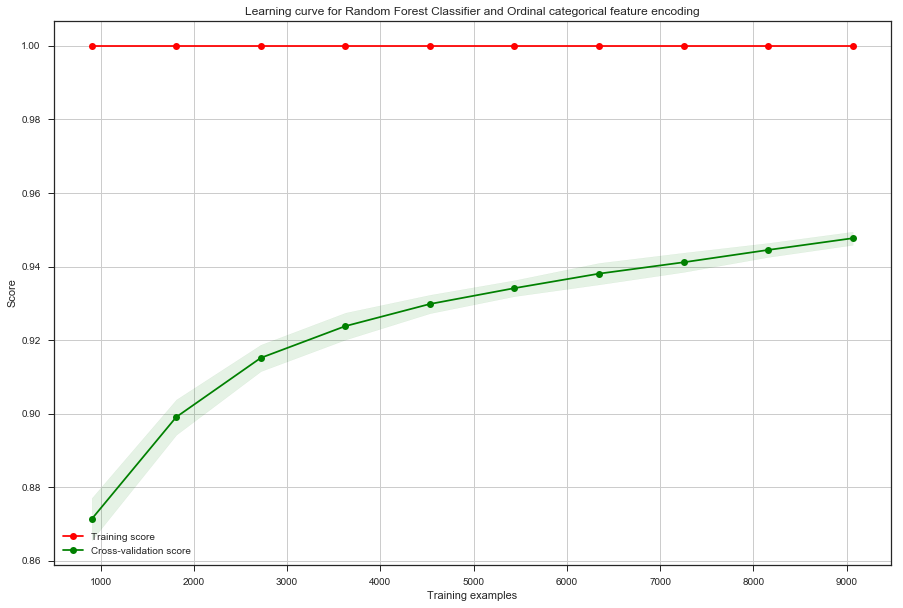

In [33]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_ord, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_ord = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_ord, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ord)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Ordinal categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Ordinal.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Ordinal categorical feature encoding', 
                    Results_ord.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Ordinal.png', dpi=200)

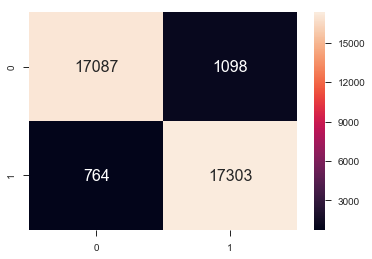

In [34]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_ord)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Polynomial encoding

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     18185
          1       0.97      0.97      0.97     18067

avg / total       0.97      0.97      0.97     36252



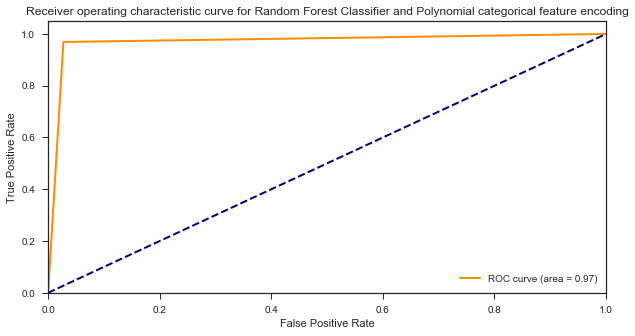

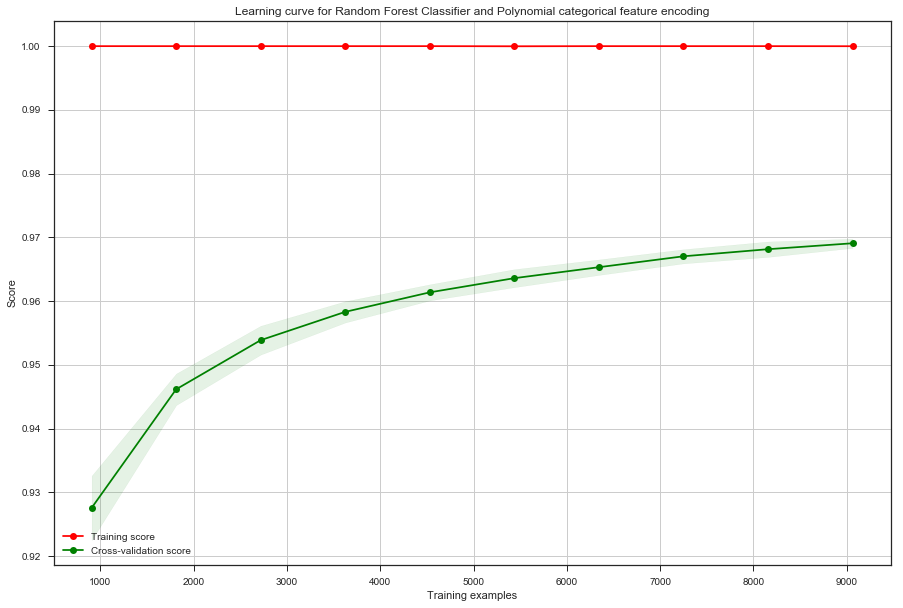

In [35]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_poly, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_poly = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_poly, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_poly)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Polynomial categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Polynomial.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Polynomial categorical feature encoding', 
                    Results_poly.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Polynomial.png', dpi=200)

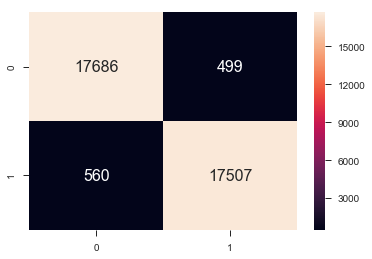

In [36]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_poly)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Sum encoding

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     18185
          1       0.97      0.97      0.97     18067

avg / total       0.97      0.97      0.97     36252



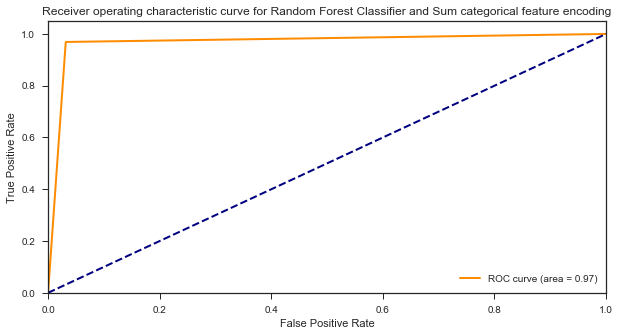

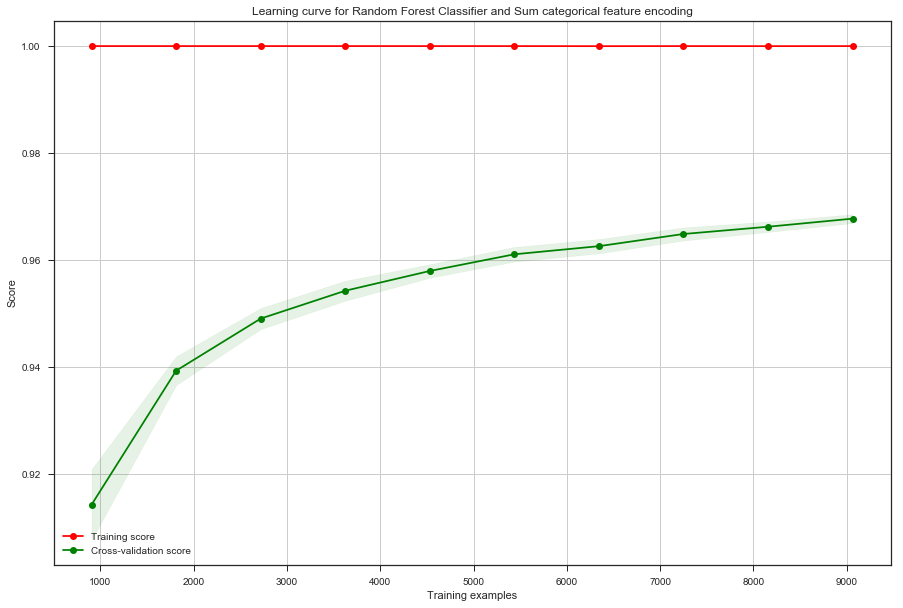

In [37]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

X_train, X_test, y_train, y_test = train_test_split(Results_sum, y_classes, test_size=0.8, random_state=1337)
y_train = y_train.ravel().astype('int')
y_test = y_test.ravel().astype('int')

rndForest.fit(X_train,y_train)
y_pred_sum = rndForest.predict(X_test)

#Show classification report
print(classification_report(y_test, y_pred_sum, labels=(0,1)))

#Print ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sum)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for Random Forest Classifier and Sum categorical feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_Sum.png', dpi=200)
plt.show()

cv = ShuffleSplit(n_splits=10, test_size=0.8, random_state=1337)

#Print learning curve
plot_learning_curve(rndForest, 'Learning curve for Random Forest Classifier and Sum categorical feature encoding', 
                    Results_sum.values, y_classes, ylim=None, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('LearningCurve_Sum.png', dpi=200)

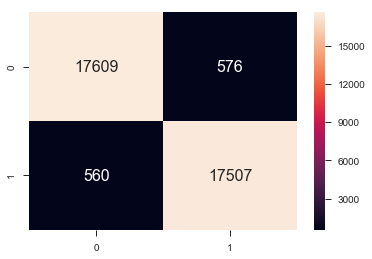

In [38]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_pred_sum)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

### Improving model performance by stacking classifiers

#### Run a for loop to iterate and train over all encodings

In [39]:
rndForest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, max_depth=None, 
                                  min_samples_leaf=1, max_leaf_nodes=None)

class0_prob = np.empty((36252, 9))
class1_prob = np.empty((36252, 9))

i=0
for encoding in processed_data:
    X_train, X_test, y_train, y_test = train_test_split(processed_data[encoding], y_classes, 
                                                        test_size=0.8, random_state=1337)
    y_train = y_train.ravel().astype('int')
    y_test = y_test.ravel().astype('int')
    
    rndForest.fit(X_train,y_train)
    y_pred = rndForest.predict_proba(X_test)
    class0_prob[:,i] = y_pred[:, 0]
    class1_prob[:, i] = y_pred[:, 1]
    i +=1

#### Use the average predicted probabilities to calculate the predicted class

In [40]:
class0_average = class0_prob.mean(axis=1).reshape(-1,1)
class1_average = class1_prob.mean(axis=1).reshape(-1,1)

y_stacked_pobas = np.concatenate((class0_average, class1_average), axis=1)

y_stacked_pred = np.argmax(y_stacked_pobas, axis=1)
y_stacked_pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

#### Plot confusion matrix of the stacked model

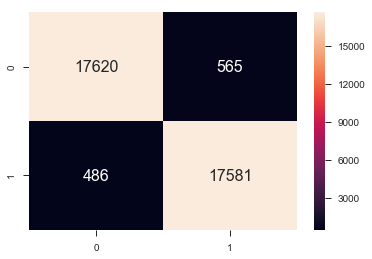

In [41]:
#Create our confusion matrix [object]
cm = confusion_matrix(y_test, y_stacked_pred)

#Plot confusion matrix to visualise performance
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

### Feature importances

Feature ranking:
1. feature 12 (0.148382)
2. feature 13 (0.146242)
3. feature 6 (0.097798)
4. feature 16 (0.089563)
5. feature 0 (0.047190)
6. feature 5 (0.043291)
7. feature 10 (0.041577)
8. feature 8 (0.039989)
9. feature 7 (0.039036)
10. feature 15 (0.037709)
11. feature 14 (0.036286)
12. feature 17 (0.035593)
13. feature 1 (0.035286)
14. feature 9 (0.034153)
15. feature 4 (0.029438)
16. feature 18 (0.028524)
17. feature 3 (0.026738)
18. feature 11 (0.023797)
19. feature 2 (0.019409)


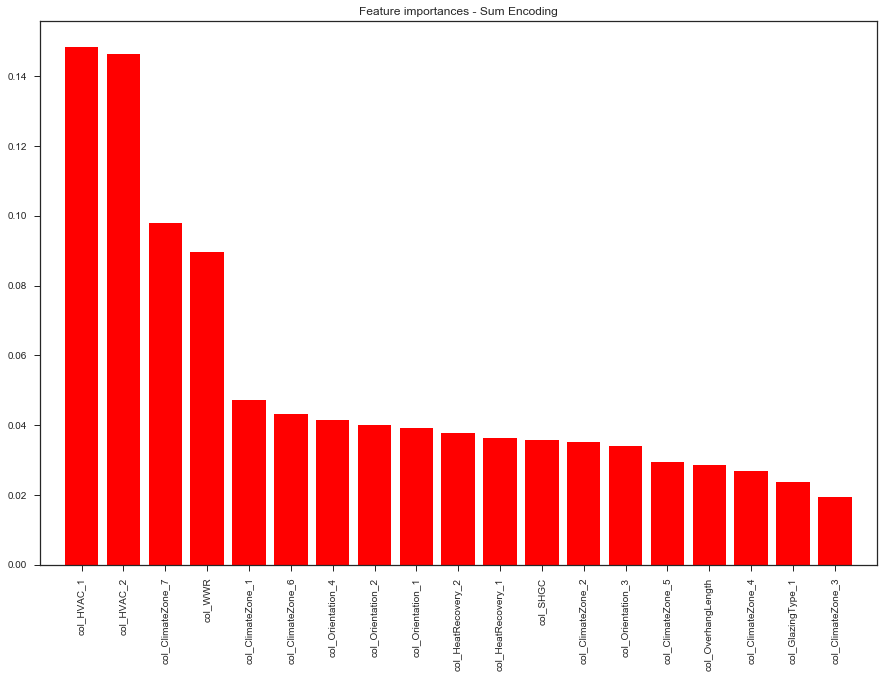

In [43]:
#Calculate, rank, and plot feature importance - Sum encoding
importances_sum = rndForest.feature_importances_
std_sum = np.std([rndForest.feature_importances_ for estimator in rndForest.estimators_],
             axis=0)
indices_sum = np.argsort(importances_sum)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Results_sum.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_sum[f], importances_sum[indices_sum[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances - Sum Encoding")
plt.bar(range(Results_sum.shape[1]), importances_sum[indices_sum], label=importances_sum[indices_sum],
       color="r", yerr=std_sum[indices_sum], align="center")
plt.xticks(range(Results_sum.shape[1]), Results_sum.columns[indices_sum], rotation=90)
plt.xlim([-1, Results_sum.shape[1]])
plt.savefig('FeatureImportance_sum')
plt.show()